In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import math
from copy import deepcopy
from circuit_partition import *

In [2]:
os.makedirs("plots", exist_ok=True)

In [3]:
d = 4
k = 3
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)
measure_qubits_ord_kxk = get_measure_qubits_ord(k)
data_qubits_ord_kxk = get_data_qubits_ord(k)

In [4]:
# Plot the dxd array

def plot_qubits(data, measure, d, kernels = [], point_size = 400, save = None):
  arr_data = []
  arr_measure_Z = []
  arr_measure_X = []

  for q in data:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    arr_data.append([x, y])
  for q in measure:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    lbl = q[1]
    if lbl=="M:Z":
      arr_measure_Z.append([x, y])
    else:
      arr_measure_X.append([x, y])

  arr_data = np.array(arr_data)
  arr_measure_Z = np.array(arr_measure_Z)
  arr_measure_X = np.array(arr_measure_X)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(arr_data[:,0], arr_data[:,1], label='Data qubits', s=point_size, marker='o', facecolors='none', edgecolors='black')
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='gray', edgecolors='black', alpha=0.5)
  ax.scatter(arr_measure_Z[:,0], arr_measure_Z[:,1], label='Measure Z', s=point_size, marker='o', facecolors='orange', edgecolors='orange', alpha=0.5)
  ax.scatter(arr_measure_X[:,0], arr_measure_X[:,1], label='Measure X', s=point_size, marker='o', facecolors='blue', edgecolors='blue', alpha=0.5)
  for iq in range(arr_measure_Z.shape[0]):
    ax.text(arr_measure_Z[iq, 0], arr_measure_Z[iq, 1], 'Z', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_measure_X.shape[0]):
    ax.text(arr_measure_X[iq, 0], arr_measure_X[iq, 1], 'X', fontsize=12, color='black', ha='center', va='center')
  for iq in range(arr_data.shape[0]):
    ax.text(arr_data[iq, 0], arr_data[iq, 1], 'D', fontsize=12, color='black', ha='center', va='center')

  # Draw an envelope that encloses kernel_data nad kernel_measure qubits, which are a subset of data and measure qubits already drawn
  for kernel in kernels:
    kernel_data = kernel['data']
    kernel_measure = kernel['measure']
    kernel_color = kernel['color']
    kernel_alpha = (0.45 if 'alpha' not in kernel else kernel['alpha'])
    kernel_offset = ([0.,0.] if 'offset' not in kernel else kernel['offset'])
    arr_kernel = []
    for q in kernel_data:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    for q in kernel_measure:
      coords = q[2]
      x = coords[0]
      y = 2*d - coords[1]
      arr_kernel.append([x, y])
    arr_kernel = np.array(arr_kernel, dtype=np.float64)
    arr_kernel[:,0] += kernel_offset[0]
    arr_kernel[:,1] += kernel_offset[1]
    # Make a set of lines that enclose the outer edges of the kernel data or measure qubits
    for iq in range(arr_kernel.shape[0]):
      for iedge in range(4):
        if iedge==0: # Top edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]>arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]+0.5+offset, arr_kernel[iq][1]+0.5+offset], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==1: # Bottom edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][0]-arr_kernel[iq][0])==1 and arr_kernel[jq][1]-arr_kernel[iq][1]==-1:
              boundn += 1
            if arr_kernel[jq][0]!=arr_kernel[iq][0]:
              continue
            if arr_kernel[jq][1]<arr_kernel[iq][1]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5, arr_kernel[iq][0]+0.5], [arr_kernel[iq][1]-0.5-offset, arr_kernel[iq][1]-0.5-offset], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==2: # Left edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==-1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]<arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]-0.5-offset, arr_kernel[iq][0]-0.5-offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)
        elif iedge==3: # Right edge
          nodraw = False
          boundn = 0
          for jq in range(arr_kernel.shape[0]):
            if np.abs(arr_kernel[jq][1]-arr_kernel[iq][1])==1 and arr_kernel[jq][0]-arr_kernel[iq][0]==1:
              boundn += 1
            if arr_kernel[jq][1]!=arr_kernel[iq][1]:
              continue
            if arr_kernel[jq][0]>arr_kernel[iq][0]:
              nodraw = True
              break
          offset = 0
          if boundn==2:
            offset = 1
          if not nodraw:
            ax.plot([arr_kernel[iq][0]+0.5+offset, arr_kernel[iq][0]+0.5+offset], [arr_kernel[iq][1]-0.5, arr_kernel[iq][1]+0.5], color=kernel_color, linestyle='--', linewidth=4, alpha=kernel_alpha)

  # Remove axis labels
  ax.set_xticks([])
  ax.set_yticks([])
  #ax.legend()
  fig.set_dpi(120)
  plt.grid(False)
  if save is not None:
    plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")

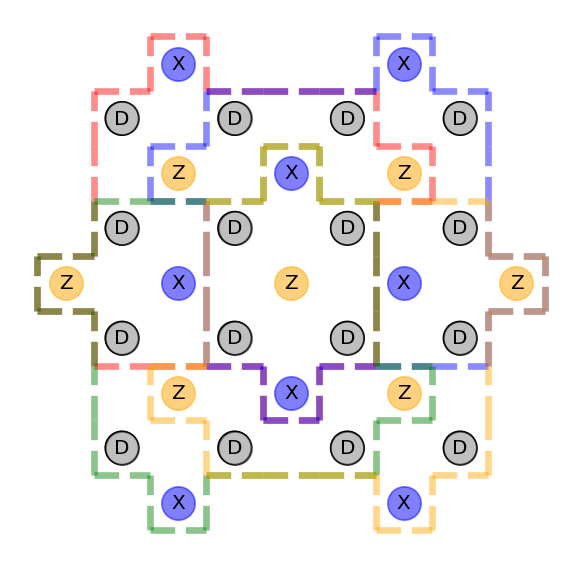

In [5]:
shifted_data_kxk_TL, shifted_measure_kxk_TL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
shifted_data_kxk_TR, shifted_measure_kxk_TR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 0)
shifted_data_kxk_BL, shifted_measure_kxk_BL = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 1)
shifted_data_kxk_BR, shifted_measure_kxk_BR = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)


plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, 
  [
    {'data' : shifted_data_kxk_TL, 'measure' : shifted_measure_kxk_TL, 'color' : 'red'},
    {'data' : shifted_data_kxk_TR, 'measure' : shifted_measure_kxk_TR, 'color' : 'blue'},
    {'data' : shifted_data_kxk_BL, 'measure' : shifted_measure_kxk_BL, 'color' : 'green'},
    {'data' : shifted_data_kxk_BR, 'measure' : shifted_measure_kxk_BR, 'color' : 'orange'}
  ],
  save = "d4_kernels.pdf"
)

In [6]:
d = 9
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

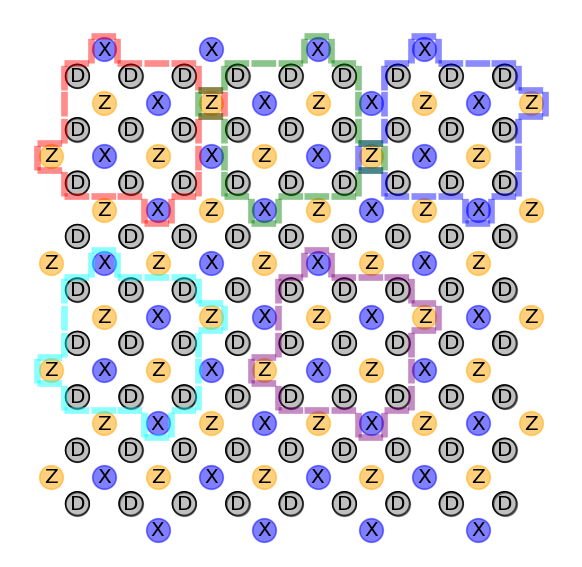

In [7]:
kernels5=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 6, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 0)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'green'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 0, 4)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'cyan'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 4, 4)
kernels5.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'purple'})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels5, point_size = 200,
  save = "kernel_types.pdf"
)

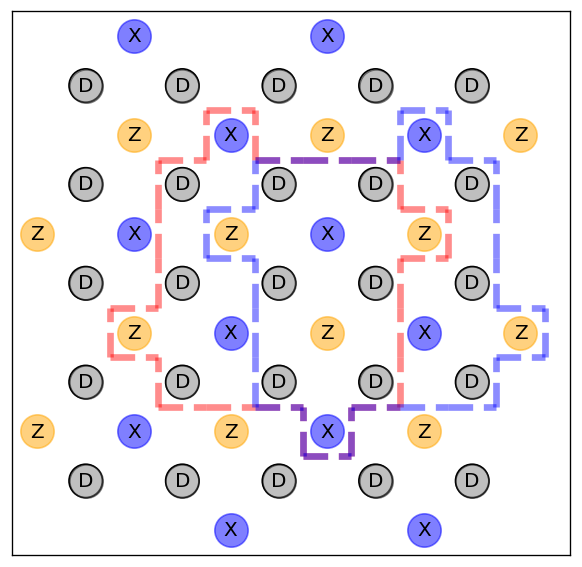

In [8]:
d = 5
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

kernels=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red'})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue'})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels
)

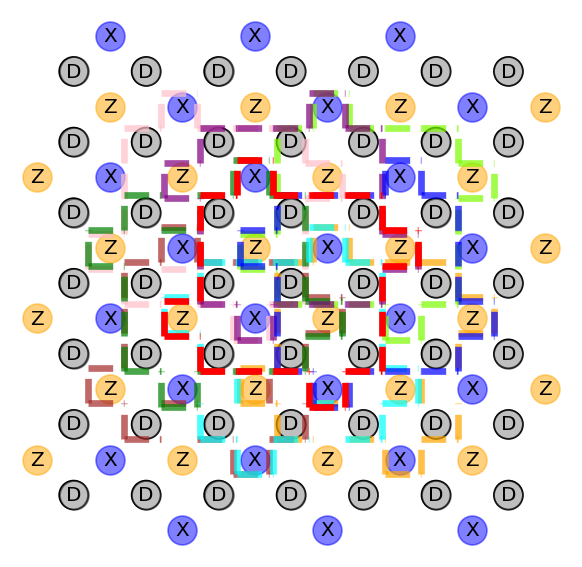

In [9]:
d = 7
measure_qubits_ord_dxd = get_measure_qubits_ord(d)
data_qubits_ord_dxd = get_data_qubits_ord(d)

kernels=[]

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'orange', 'alpha':0.7, 'offset':[0.1,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'pink', 'alpha':0.7, 'offset':[-0.1,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'lawngreen', 'alpha':0.7, 'offset':[0.1,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'brown', 'alpha':0.7, 'offset':[-0.1,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 1, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'green', 'alpha':0.7, 'offset':[-0.1,0.]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 1)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'purple', 'alpha':0.7, 'offset':[0.,-0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 3)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'cyan', 'alpha':0.7, 'offset':[0.,0.1]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 3, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'blue', 'alpha':0.7, 'offset':[0.1,0.]})

shifted_data_kxk, shifted_measure_kxk = shift_frame(data_qubits_ord_kxk, measure_qubits_ord_kxk, k, d, 2, 2)
kernels.append({'data':shifted_data_kxk, 'measure':shifted_measure_kxk, 'color':'red', 'alpha':1.})

plot_qubits(
  data_qubits_ord_dxd, measure_qubits_ord_dxd, d, kernels, point_size=300, save = 'd7_q25_kernels.pdf'
)

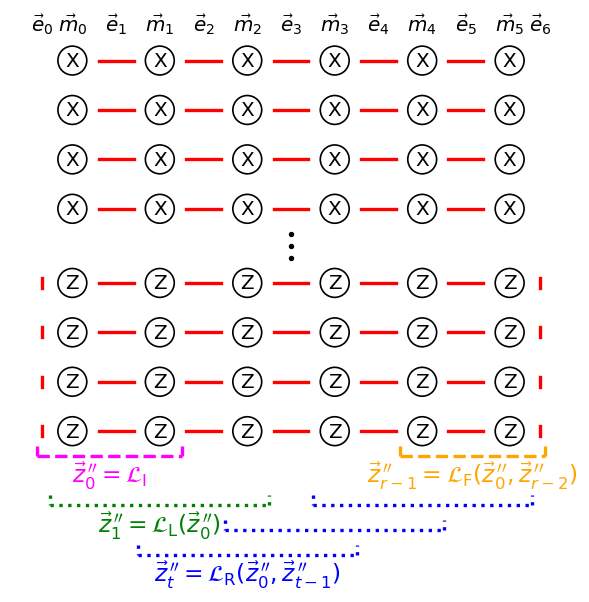

In [10]:
def plot_RCNN_layer_progression(d, r, save=None):
  na = d**2-1

  points_stabilizer = [ (x, y) for y in range(na//2) for x in range(r) ]
  points_etc = [ ((r-1)/2, points_stabilizer[-1][1] + 0.5 + 0.25*y) for y in range(3) ]
  points_stabilizer.extend([ (x, y + points_etc[-1][1] + 0.5) for y in range(na//2) for x in range(r) ])
  lines_detector = [ (-0.35, y-0.1, -0.35, y+0.1) for y in range(na//2) ]
  lines_detector.extend([ (x+0.3, y, x+0.7, y) for y in range(na//2) for x in range(r-1)  ])
  lines_detector.extend([ (x+0.3, y + points_etc[-1][1] + 0.5, x+0.7, y + points_etc[-1][1] + 0.5) for y in range(na//2) for x in range(r-1)  ])
  lines_detector.extend([ (r-1+0.35, y-0.1, r-1+0.35, y+0.1) for y in range(na//2) ])
  dxbrf = 0.4
  dxbrl = 0.25
  dybr = 0.2
  y0br = -0.3
  yoffsetbr = 1.
  bracket = {
    'points' : [
      [-dxbrl, y0br, -dxbrl, y0br-dybr],
      [-dxbrl, y0br-dybr, 2+dxbrl, y0br-dybr],
      [2+dxbrl, y0br-dybr, 2+dxbrl, y0br]
    ],
    'color' : 'black',
    'style' : '--'
  }
  brackets = [ deepcopy(bracket) for _ in range(r) ]
  brackets[0]['color'] = 'magenta'
  brackets[0]['points'] = [
    [-dxbrf, y0br, -dxbrf, y0br-dybr],
    [-dxbrf, y0br-dybr, 1+dxbrl, y0br-dybr],
    [1+dxbrl, y0br-dybr, 1+dxbrl, y0br]
  ]
  brackets[1]['color'] = 'green'
  brackets[1]['style'] = ':'
  for lb in brackets[1]['points']:
    lb[1] -= yoffsetbr
    lb[3] -= yoffsetbr
  for ibr in range(2, r-1):
    brackets[ibr]['color'] = 'blue'
    brackets[ibr]['style'] = ':'
    for lb in brackets[ibr]['points']:
      lb[0] += ibr-1
      lb[2] += ibr-1
      lb[1] -= yoffsetbr*(r-2-ibr)/2 + yoffsetbr
      lb[3] -= yoffsetbr*(r-2-ibr)/2 + yoffsetbr
  brackets[r-1]['color'] = 'orange'
  brackets[r-1]['points'] = [
    [r-2-dxbrl, y0br, r-2-dxbrl, y0br-dybr],
    [r-2-dxbrl, y0br-dybr, r-1+dxbrf, y0br-dybr],
    [r-1+dxbrf, y0br-dybr, r-1+dxbrf, y0br]
  ]

  ymlabel = None

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter([x for x, _ in points_stabilizer], [y for _, y in points_stabilizer], s=300, marker='o', facecolors='none', edgecolors='black')
  ax.scatter([x for x, _ in points_etc], [y for _, y in points_etc], s=5, marker='o', facecolors='black', edgecolors='black')
  for ips, ps in enumerate(points_stabilizer):
    x, y = ps
    if y<na//2:
      ax.text(x, y, 'Z', fontsize=12, color='black', ha='center', va='center')
    else:
      ax.text(x, y, 'X', fontsize=12, color='black', ha='center', va='center')
    if ips>=(r-1)*na+2:
      idx = ips-2-(r-1)*na
      ymlabel = y + 0.75
      ax.text(x, ymlabel, f'$\\vec{{m}}_{idx}$', fontsize=12, color='black', ha='center', va='center')
  
  for lp in lines_detector:
    ax.plot([lp[0], lp[2]], [lp[1], lp[3]], linestyle='-', linewidth=2, color='red')

  for ild in range(r-1):
    ax.text(ild+0.5, ymlabel, f'$\\vec{{e}}_{ild+1}$', fontsize=12, color='black', ha='center', va='center')
  ax.text(-0.35, ymlabel, '$\\vec{{e}}_0$', fontsize=12, color='black', ha='center', va='center')
  ax.text(r-1+0.35, ymlabel, f'$\\vec{{e}}_{r}$', fontsize=12, color='black', ha='center', va='center')

  for ibb, bb in enumerate(brackets):
    for ilb, lb in enumerate(bb['points']):
      ax.plot([lb[0], lb[2]], [lb[1], lb[3]], linestyle=bb['style'], linewidth=2, color=bb['color'])
      if ilb==1:
        xt = (lb[0]+lb[2])/2
        yt = (lb[1]+lb[3])/2 - yoffsetbr*0.4
        layer_label = None
        if ibb == 0:
          layer_label = r"$\vec{z}^{\,\prime\prime}_{0}=\mathcal{L}_\text{I}$"
        elif ibb == 1:
          layer_label = r"$\vec{z}^{\,\prime\prime}_{1}=\mathcal{L}_\text{L}(\vec{z}^{\,\prime\prime}_{0})$"
        elif ibb == 2:
          layer_label = r"$\vec{z}^{\,\prime\prime}_{t}=\mathcal{L}_\text{R}(\vec{z}^{\,\prime\prime}_{0}, \vec{z}^{\,\prime\prime}_{t-1})$"
        elif ibb == r-1:
          layer_label = r"$\vec{z}^{\,\prime\prime}_{r-1}=\mathcal{L}_\text{F}(\vec{z}^{\,\prime\prime}_{0}, \vec{z}^{\,\prime\prime}_{r-2})$"
        if layer_label is not None:
          ax.text(xt, yt, layer_label, fontsize=14, color=bb['color'], ha='center', va='center')
  
  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_RCNN_layer_progression(3, 6, save='RCNN_layer_progression_d3_r6.pdf')

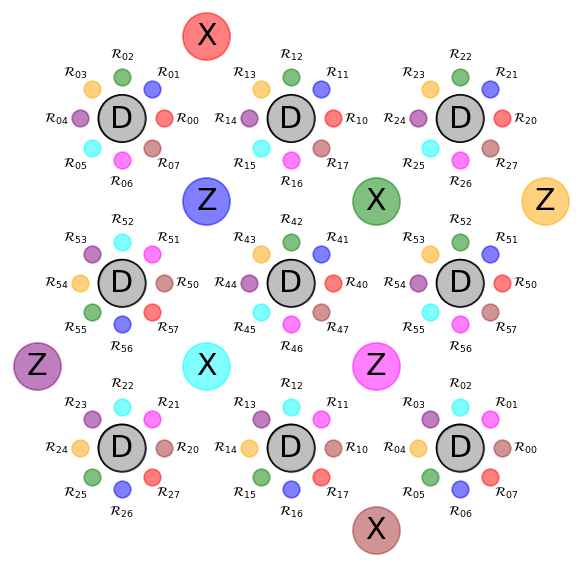

In [11]:
def plot_symkernel_output_relation(save=None):
  k=3
  point_size = 800
  measure = get_measure_qubits_ord(k)
  measure.sort()
  data = get_data_qubits_ord(k)
  data.sort()
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

  arr_data = []
  arr_measure = []
  idxs_Z = []
  idxs_X = []

  for q in data:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    arr_data.append([x, y])
  for q in measure:
    coords = q[2]
    x = coords[0]
    y = 2*d - coords[1]
    lbl = q[1]
    if lbl=="M:Z":
      idxs_Z.append(len(arr_measure))
    else:
      idxs_X.append(len(arr_measure))
    arr_measure.append([x, y])

  arr_data = np.array(arr_data)
  arr_measure = np.array(arr_measure)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='none', edgecolors='black')
  ax.scatter(arr_data[:,0], arr_data[:,1], s=point_size, marker='o', facecolors='gray', edgecolors='black', alpha=0.5)
  for iq in range(arr_data.shape[0]):
    ax.text(arr_data[iq, 0], arr_data[iq, 1], 'D', fontsize=18, color='black', ha='center', va='center')
  for im in range(arr_measure.shape[0]):
    ax.scatter(arr_measure[im,0], arr_measure[im,1], s=point_size, marker='o', facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
    if im in idxs_Z:
      ax.text(arr_measure[im, 0], arr_measure[im, 1], 'Z', fontsize=18, color='black', ha='center', va='center')
    else:
      ax.text(arr_measure[im, 0], arr_measure[im, 1], 'X', fontsize=18, color='black', ha='center', va='center')
    for iq in range(arr_data.shape[0]):
      x = arr_data[iq,0]
      y = arr_data[iq,1]

      swap = (iq==3 or iq>=6)
      jq = iq if not swap else 8-iq
      jm = im if not swap else 7-im
      angle = jm*2*np.pi/arr_measure.shape[0]
      
      ax.scatter(x+0.5*np.cos(angle), y+0.5*np.sin(angle), color=colors[im], marker='o', s=point_size//8, facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
      ax.text(x+0.775*np.cos(angle), y+0.775*np.sin(angle), f'$\\mathcal{{R}}_{{{jq}{jm}}}$', fontsize=8, color='black', ha='center', va='center')
      #ax.scatter(x+0.765*np.cos(angle), y+0.765*np.sin(angle), color=colors[im], marker='o', s=point_size//8, facecolors=colors[im], edgecolors=colors[im], alpha=0.5)
      #ax.text(x+0.5*np.cos(angle), y+0.5*np.sin(angle), f'$\\mathcal{{R}}_{{{jq}{jm}}}$', fontsize=8, color='black', ha='center', va='center')

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')
  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")

plot_symkernel_output_relation("symmetric_kernel_output_relation.pdf")

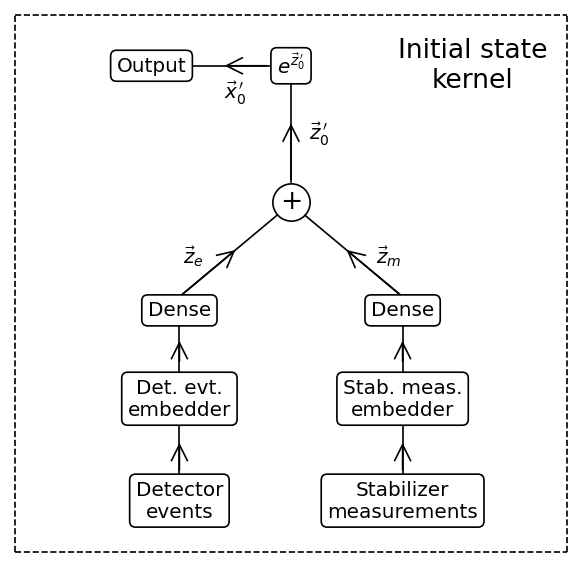

In [12]:
def plot_initial_kernel_architecture(save = None):
  fig, ax = plt.subplots(figsize=(6, 6))

  ax.set(xlim=(0, 1), ylim=(0, 1))
  rf = 0.025/4.
  ax.plot([rf, 1.-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, 1.-rf], [1.-rf, 1.-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, 1.-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([1.-rf, 1.-rf], [rf, 1.-rf], color='black', linestyle='--', linewidth=1)
  ax.text(.825, .9, "Initial state\nkernel", fontsize=16, color="black", ha="center", va="center")

  ax.text(.3, .1, "Detector\nevents", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7, .1, "Stabilizer\nmeasurements", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3, .3], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3, .2125), xytext=(.3, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7, .7], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7, .2125), xytext=(.7, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3, .2875, "Det. evt.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7, .2875, "Stab. meas.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3, .3], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3, .4), xytext=(.3, .35), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7, .7], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7, .4), xytext=(.7, .35), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  rf = 0.025
  ax.plot([.3, .5-rf], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+(.2-rf)*.6, .475+(.65-rf-.475)*.6), xytext=(.3, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.325, .55, "$\\vec{{z}}_{{e}}$", fontsize=12, color="black", ha="center", va="center")
  ax.plot([.7, .5+rf], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7+(-.2+rf)*.6, .475+(.65-rf-.475)*.6), xytext=(.7, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(1.-.325, .55, "$\\vec{{z}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")

  ax.scatter(0.5, 0.65, color='black', marker='o', s=500, facecolors='white', edgecolors='black')
  ax.text(.5, .65, "+", fontsize=16, color="black", ha="center", va="center")

  ax.plot([.5, .5], [.65+rf*math.sqrt(2.), 0.875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.5, .8), xytext=(.5, .65+rf*math.sqrt(2.)), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.55, .775, "$\\vec{{z}}^{{\\,\\prime}}_{{0}}$", fontsize=12, color="black", ha="center", va="center")

  ax.text(.5, .9, "$e^{{\\vec{{z}}^{{\\,\\prime}}_{{0}}}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.4625, .325], [.9, .9], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.375, .9), xytext=(.4625, .9), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.4, .85, "$\\vec{{x}}^{{\\,\\prime}}_{{0}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(.25, .9, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_initial_kernel_architecture("initial_state_kernel_architecture.pdf")

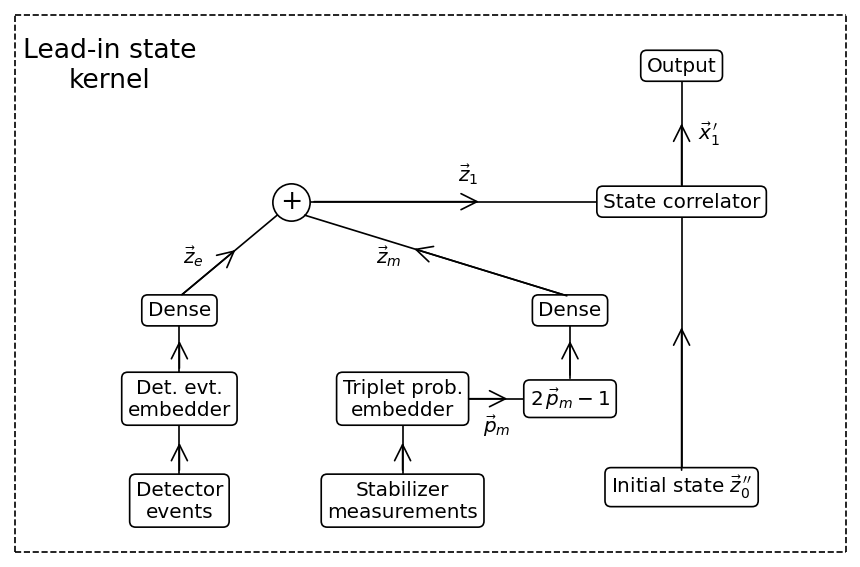

In [13]:
def plot_leadin_kernel_architecture(save = None):
  xmax = 1.5
  ymax = 1.
  xoff = 0.

  fig, ax = plt.subplots(figsize=(int(6*xmax), int(6*ymax)))

  ax.set(xlim=(0, xmax), ylim=(0, ymax))
  rf = 0.025/4.
  ax.plot([rf, xmax-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, xmax-rf], [ymax-rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([xmax-rf, xmax-rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.text(0.175, ymax-0.1, "Lead-in state\nkernel", fontsize=16, color="black", ha="center", va="center")

  ax.text(.3, .1, "Detector\nevents", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7, .1, "Stabilizer\nmeasurements", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(xmax-0.3, .1, "Initial state $\\vec{{z}}^{{\\,\\prime\\prime}}_{{0}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="bottom")

  ax.plot([.3, .3], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3, .2125), xytext=(.3, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7, .7], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7, .2125), xytext=(.7, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3, .2875, "Det. evt.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7, .2875, "Triplet prob.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.8125+xoff, .925+xoff], [.2875, .2875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=((.8125+.925)/2+0.025+xoff, .2875), xytext=(.8125+xoff, .2875), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((.8125+.925)/2+xoff, .2375, "$\\vec{{p}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(1.+xoff, .2875, "$2\,\\vec{{p}}_{{m}}-1$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3+xoff, .3+xoff], [.3375, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+xoff, .4), xytext=(.3+xoff, .3375), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([1.0+xoff, 1.0+xoff], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(1.0+xoff, .4), xytext=(1.0+xoff, .325), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(1.0+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  rf = 0.025
  ax.plot([.3+xoff, .5-rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+(.2-rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(.3+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.325+xoff, .55, "$\\vec{{z}}_{{e}}$", fontsize=12, color="black", ha="center", va="center")
  ax.plot([1.0+xoff, .5+rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(1.0+(-.5+rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(1.0+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(1.-.325+xoff, .55, "$\\vec{{z}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")

  ax.scatter(0.5, 0.65, color='black', marker='o', s=500, facecolors='white', edgecolors='black')
  ax.text(.5, .65, "+", fontsize=16, color="black", ha="center", va="center")

  ax.plot([.5+rf*math.sqrt(2.), xmax-0.45], [.65, .65], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=((.5+rf*math.sqrt(2.) + xmax-0.45)/2+0.05, .65), xytext=(.5+rf*math.sqrt(2.), 0.65), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((.5+rf*math.sqrt(2.) + xmax-0.45)/2+0.025, .7, "$\\vec{{z}}_{{1}}$", fontsize=12, color="black", ha="center", va="center")

  ax.plot([xmax-0.3, xmax-0.3], [.15, .625], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.3, .425), xytext=(xmax-0.3, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(xmax-0.3, .65, "State correlator", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([xmax-0.3, xmax-0.3], [.675, 0.875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.3, .8), xytext=(xmax-0.3, .675), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(xmax-0.3+.05, .775, "$\\vec{{x}}^{{\\,\\prime}}_{{1}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(xmax-0.3, .9, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_leadin_kernel_architecture("leadin_state_kernel_architecture.pdf")

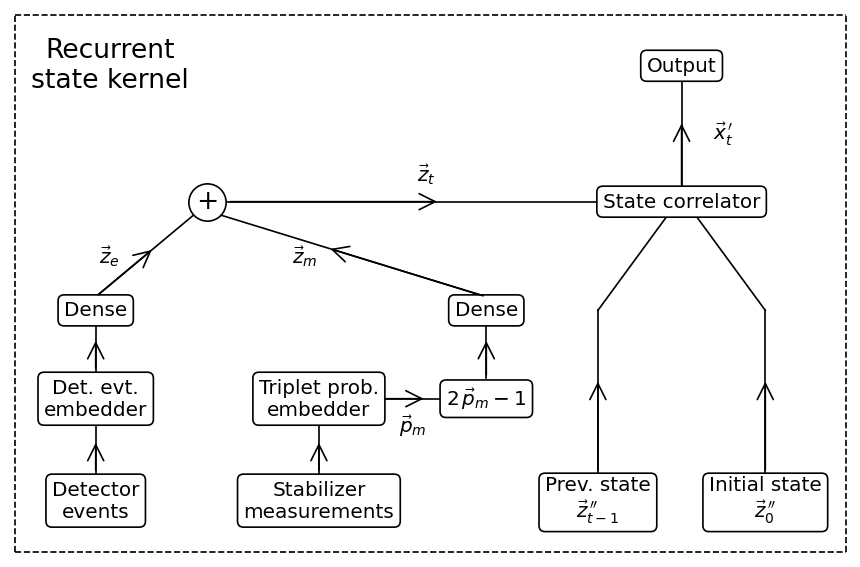

In [14]:
def plot_recurrent_kernel_architecture(save = None):
  xmax = 1.5
  ymax = 1.
  xoff = -0.15

  fig, ax = plt.subplots(figsize=(int(6*xmax), int(6*ymax)))

  ax.set(xlim=(0, xmax), ylim=(0, ymax))
  rf = 0.025/4.
  ax.plot([rf, xmax-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, xmax-rf], [ymax-rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([xmax-rf, xmax-rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.text(0.175, ymax-0.1, "Recurrent\nstate kernel", fontsize=16, color="black", ha="center", va="center")

  ax.text(.3+xoff, .1, "Detector\nevents", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7+xoff, .1, "Stabilizer\nmeasurements", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3+xoff, .3+xoff], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+xoff, .2125), xytext=(.3+xoff, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7+xoff, .7+xoff], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7+xoff, .2125), xytext=(.7+xoff, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3+xoff, .2875, "Det. evt.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7+xoff, .2875, "Triplet prob.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.8125+xoff, .925+xoff], [.2875, .2875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=((.8125+.925)/2+0.025+xoff, .2875), xytext=(.8125+xoff, .2875), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((.8125+.925)/2+xoff, .2375, "$\\vec{{p}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(1.+xoff, .2875, "$2\,\\vec{{p}}_{{m}}-1$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3+xoff, .3+xoff], [.3375, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+xoff, .4), xytext=(.3+xoff, .3375), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([1.0+xoff, 1.0+xoff], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(1.0+xoff, .4), xytext=(1.0+xoff, .325), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(1.0+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  rf = 0.025
  ax.plot([.3+xoff, .5-rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+(.2-rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(.3+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.325+xoff, .55, "$\\vec{{z}}_{{e}}$", fontsize=12, color="black", ha="center", va="center")
  ax.plot([1.0+xoff, .5+rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(1.0+(-.5+rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(1.0+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(1.-.325+xoff, .55, "$\\vec{{z}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")

  ax.scatter(0.5+xoff, 0.65, color='black', marker='o', s=500, facecolors='white', edgecolors='black')
  ax.text(.5+xoff, .65, "+", fontsize=16, color="black", ha="center", va="center")

  ax.plot([.5+rf*math.sqrt(2.)+xoff, xmax-0.45], [.65, .65], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=((.5+rf*math.sqrt(2.)+xoff + xmax-0.45)/2+0.05, .65), xytext=(.5+rf*math.sqrt(2.)+xoff, 0.65), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((.5+rf*math.sqrt(2.)+xoff + xmax-0.45)/2+0.025, .7, "$\\vec{{z}}_{{t}}$", fontsize=12, color="black", ha="center", va="center")

  ax.text(xmax-0.15, .1, "Initial state\n$\\vec{{z}}^{{\\,\\prime\\prime}}_{{0}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([xmax-0.15, xmax-0.15], [.15, .45], color='black', linestyle='-', linewidth=1)
  ax.plot([xmax-0.15, xmax-0.275], [.45, .625], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.15, .325), xytext=(xmax-0.15, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(xmax-0.45, .1, "Prev. state\n$\\vec{{z}}^{{\\,\\prime\\prime}}_{{t-1}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([xmax-0.45, xmax-0.45], [.15, .45], color='black', linestyle='-', linewidth=1)
  ax.plot([xmax-0.45, xmax-0.325], [.45, .625], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.45, .325), xytext=(xmax-0.45, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(xmax-0.3, .65, "State correlator", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([xmax-0.3, xmax-0.3], [.675, 0.875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.3, .8), xytext=(xmax-0.3, .675), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(xmax-0.3+.075, .775, "$\\vec{{x}}^{{\\,\\prime}}_{{t}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(xmax-0.3, .9, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_recurrent_kernel_architecture("recurrent_state_kernel_architecture.pdf")

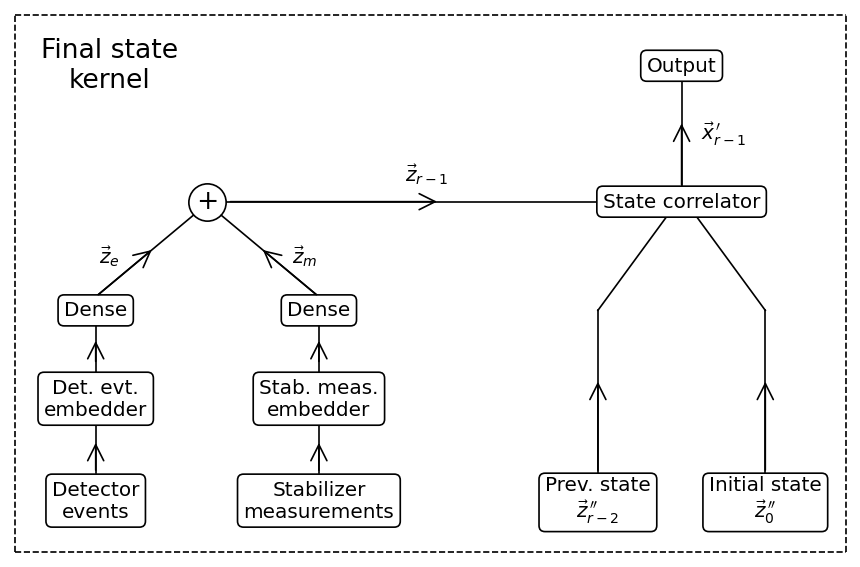

In [15]:
def plot_final_kernel_architecture(save = None):
  xmax = 1.5
  ymax = 1.
  xoff = -0.15

  fig, ax = plt.subplots(figsize=(int(6*xmax), int(6*ymax)))

  ax.set(xlim=(0, xmax), ylim=(0, ymax))
  rf = 0.025/4.
  ax.plot([rf, xmax-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, xmax-rf], [ymax-rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([xmax-rf, xmax-rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.text(0.175, ymax-0.1, "Final state\nkernel", fontsize=16, color="black", ha="center", va="center")

  ax.text(.3+xoff, .1, "Detector\nevents", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7+xoff, .1, "Stabilizer\nmeasurements", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3+xoff, .3+xoff], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+xoff, .2125), xytext=(.3+xoff, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7+xoff, .7+xoff], [.15, .2375], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7+xoff, .2125), xytext=(.7+xoff, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3+xoff, .2875, "Det. evt.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7+xoff, .2875, "Stab. meas.\nembedder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([.3+xoff, .3+xoff], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+xoff, .4), xytext=(.3+xoff, .35), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([.7+xoff, .7+xoff], [.325, .45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7+xoff, .4), xytext=(.7+xoff, .35), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(.3+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.text(.7+xoff, .45, "Dense", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  rf = 0.025
  ax.plot([.3+xoff, .5-rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.3+(.2-rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(.3+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(.325+xoff, .55, "$\\vec{{z}}_{{e}}$", fontsize=12, color="black", ha="center", va="center")
  ax.plot([.7+xoff, .5+rf+xoff], [.475, .65-rf], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(.7+(-.2+rf)*.6+xoff, .475+(.65-rf-.475)*.6), xytext=(.7+xoff, .475), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(1.-.325+xoff, .55, "$\\vec{{z}}_{{m}}$", fontsize=12, color="black", ha="center", va="center")

  ax.scatter(0.5+xoff, 0.65, color='black', marker='o', s=500, facecolors='white', edgecolors='black')
  ax.text(.5+xoff, .65, "+", fontsize=16, color="black", ha="center", va="center")

  ax.plot([.5+rf*math.sqrt(2.)+xoff, xmax-0.45], [.65, .65], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=((.5+rf*math.sqrt(2.)+xoff + xmax-0.45)/2+0.05, .65), xytext=(.5+rf*math.sqrt(2.)+xoff, 0.65), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((.5+rf*math.sqrt(2.)+xoff + xmax-0.45)/2+0.025, .7, "$\\vec{{z}}_{{r-1}}$", fontsize=12, color="black", ha="center", va="center")

  ax.text(xmax-0.15, .1, "Initial state\n$\\vec{{z}}^{{\\,\\prime\\prime}}_{{0}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([xmax-0.15, xmax-0.15], [.15, .45], color='black', linestyle='-', linewidth=1)
  ax.plot([xmax-0.15, xmax-0.275], [.45, .625], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.15, .325), xytext=(xmax-0.15, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(xmax-0.45, .1, "Prev. state\n$\\vec{{z}}^{{\\,\\prime\\prime}}_{{r-2}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([xmax-0.45, xmax-0.45], [.15, .45], color='black', linestyle='-', linewidth=1)
  ax.plot([xmax-0.45, xmax-0.325], [.45, .625], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.45, .325), xytext=(xmax-0.45, .15), arrowprops=dict(arrowstyle='->', color='black'), size=24)

  ax.text(xmax-0.3, .65, "State correlator", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([xmax-0.3, xmax-0.3], [.675, 0.875], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(xmax-0.3, .8), xytext=(xmax-0.3, .675), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(xmax-0.3+.075, .775, "$\\vec{{x}}^{{\\,\\prime}}_{{r-1}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(xmax-0.3, .9, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_final_kernel_architecture("final_state_kernel_architecture.pdf")

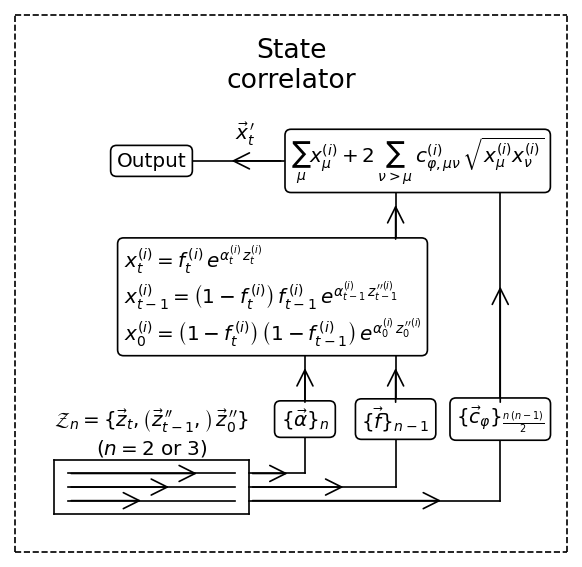

In [16]:
def plot_state_correlator_architecture(save = None):
  xmax = 1.
  ymax = 1.

  fig, ax = plt.subplots(figsize=(int(6*xmax), int(6*ymax)))

  ax.set(xlim=(0, xmax), ylim=(0, ymax))
  rf = 0.025/4.
  ax.plot([rf, xmax-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, xmax-rf], [ymax-rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([xmax-rf, xmax-rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.text(xmax/2, ymax-0.1, "State\ncorrelator", fontsize=16, color="black", ha="center", va="center")

  slabel = "$\\mathcal{{Z}}_{{n}} = \\{{\\vec{{z}}_{{t}}, \\left(\\vec{{z}}^{{\\,\\prime\\prime}}_{{t-1}},\\right)\\, \\vec{{z}}^{{\\,\\prime\\prime}}_{{0}} \\}}$\n($n=2$ or $3$)"
  nlines = 3
  for i in range(nlines):
    ax.plot([0.1, 0.4], [0.1+i*0.025, 0.1+i*0.025], color='black', linestyle='-', linewidth=1)
    ax.annotate('', xy=(0.2875+0.05*(i-1), 0.1+i*0.025), xytext=(0.1, 0.1+i*0.025), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.075, 0.425], [0.075, 0.075], color='black', linestyle='-', linewidth=1)
  ax.plot([0.075, 0.425], [0.175, 0.175], color='black', linestyle='-', linewidth=1)
  ax.plot([0.075, 0.075], [0.075, 0.175], color='black', linestyle='-', linewidth=1)
  ax.plot([0.425, 0.425], [0.075, 0.175], color='black', linestyle='-', linewidth=1)
  ax.text(0.25, 0.225, slabel, fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.425, 0.525], [0.15, 0.15], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.5, 0.15), xytext=(0.425, 0.15), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.525, 0.525], [0.15, 0.225], color='black', linestyle='-', linewidth=1)
  ax.text(0.525, .25, "$\\{{\\vec{{\\alpha}}\\}}_{{n}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([0.425, 0.6875], [0.125, 0.125], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.6, 0.125), xytext=(0.425, 0.125), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.6875, 0.6875], [0.125, 0.225], color='black', linestyle='-', linewidth=1)
  ax.text(0.6875, .25, "$\\{{\\vec{{f}}\\}}_{{n-1}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")
  ax.plot([0.425, 0.875], [0.1, 0.1], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.775, 0.1), xytext=(0.425, 0.1), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.875, 0.875], [0.1, 0.225], color='black', linestyle='-', linewidth=1)
  ax.text(0.875, .25, "$\\{{\\vec{{c}}_{{\\varphi}}\\}}_{{\\frac{{n \\, (n-1)}}{{2}}}}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")


  ax.plot([0.525, 0.525], [0.275, 0.4], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.525, 0.35), xytext=(0.525, 0.275), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.6875, 0.6875], [0.275, 0.4], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.6875, 0.35), xytext=(0.6875, 0.275), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(0.2, .475, "$x_{{t}}^{{(i)}}=f_{{t}}^{{\\,(i)}} \\, e^{{\\alpha_{{t}}^{{(i)}} \\, z_{{t}}^{{(i)}} }}$\n$x_{{t-1}}^{{(i)}}=\\left(1-f_{{t}}^{{\\,(i)}}\\right)\\,f_{{t-1}}^{{\\,(i)}} \\, e^{{\\alpha_{{t-1}}^{{(i)}} \\, z_{{t-1}}^{{\\,\\prime\\prime(i)}} }}$\n$x_{{0}}^{{(i)}}=\\left(1-f_{{t}}^{{\\,(i)}}\\right)\\,\\left(1-f_{{t-1}}^{{\\,(i)}}\\right) \\, e^{{\\alpha_{{0}}^{{(i)}} \\, z_{{0}}^{{\\,\\prime\\prime(i)}} }}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="left", va="center")

  ax.plot([0.6875, 0.6875], [0.575, 0.7], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.6875, 0.65), xytext=(0.6875, 0.575), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.875, 0.875], [0.275, 0.7], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.875, 0.5), xytext=(0.875, 0.275), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(0.5, .725, "$\\sum_{{\\mu}} x_{{\\mu}}^{{(i)}} + 2\\,\\sum_{{\\nu > \\mu}} \\,c^{{(i)}}_{{\\varphi, \\mu\\nu}} \\,\\sqrt{{ x_{{\\mu}}^{{(i)}} x_{{\\nu}}^{{(i)}} }}$", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="left", va="center")

  ax.plot([0.4875, 0.25], [0.725, 0.725], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.3875, 0.725), xytext=(0.4875, 0.725), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(0.4, .775, "$\\vec{{x}}^{{\\,\\prime}}_{{t}}$", fontsize=12, color="black", ha="left", va="center")

  ax.text(0.25, .725, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_state_correlator_architecture("state_correlator_architecture.pdf")

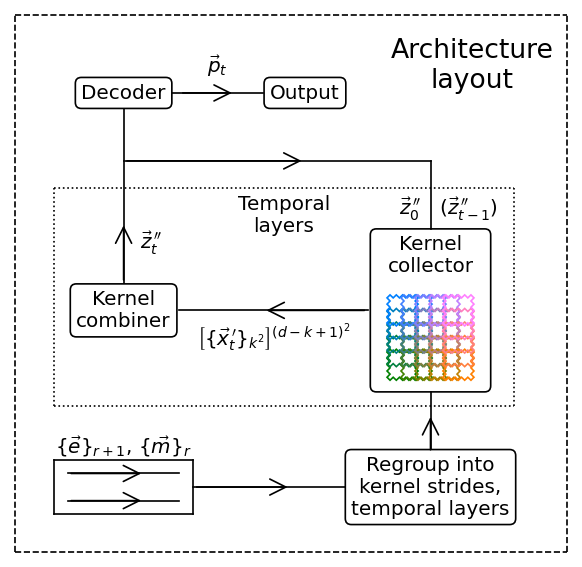

In [17]:
def plot_general_architecture_layout(save = None):
  xmax = 1.
  ymax = 1.

  fig, ax = plt.subplots(figsize=(int(6*xmax), int(6*ymax)))

  ax.set(xlim=(0, xmax), ylim=(0, ymax))
  rf = 0.025/4.
  ax.plot([rf, xmax-rf], [rf, rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, xmax-rf], [ymax-rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([rf, rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.plot([xmax-rf, xmax-rf], [rf, ymax-rf], color='black', linestyle='--', linewidth=1)
  ax.text(xmax-0.175, ymax-0.1, "Architecture\nlayout", fontsize=16, color="black", ha="center", va="center")

  nlines = 2
  for i in range(nlines):
    ax.plot([0.1, 0.3], [0.1+i*0.05, 0.1+i*0.05], color='black', linestyle='-', linewidth=1)
    ax.annotate('', xy=(0.2375, 0.1+i*0.05), xytext=(0.1, 0.1+i*0.05), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.075, 0.325], [0.075, 0.075], color='black', linestyle='-', linewidth=1)
  ax.plot([0.075, 0.325], [0.175, 0.175], color='black', linestyle='-', linewidth=1)
  ax.plot([0.075, 0.075], [0.075, 0.175], color='black', linestyle='-', linewidth=1)
  ax.plot([0.325, 0.325], [0.075, 0.175], color='black', linestyle='-', linewidth=1)
  ax.text(0.2, 0.2, "$\\{{\\vec{{e}}\\}}_{{r+1}}$, $\\{{\\vec{{m}}\\}}_{{r}}$", fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.325, 0.65], [0.125, 0.125], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.5, 0.125), xytext=(0.325, 0.125), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(0.75, .125, "Regroup into\nkernel strides,\ntemporal layers", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.75, 0.75], [0.1875, 0.3], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.75, 0.26), xytext=(0.75, 0.1875), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  for i in range(5):
    for j in range(5):
      ax.text(0.75+(i-2)*0.025, .4+(j-2)*0.025, "   ", bbox=dict(boxstyle="sawtooth", fc=(0,0,0,0), ec=(0.25*i, 0.5, 0.25*j)), fontsize=12, color="black", ha="center", va="center")
  ax.text(0.75, .45, "Kernel\ncollector\n\n\n                 \n\n", bbox=dict(boxstyle="round", fc=(0,0,0,0), ec='k'), fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.6375, 0.3], [0.45, 0.45], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.45, 0.45), xytext=(0.6375, 0.45), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((0.6375+0.3)/2, .4, "$\\left[\\{\\vec{{x}}^{{\\,\\prime}}_{{t}}\\}_{{k^2}}\\right]^{{(d-k+1)^2}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(0.2, .45, "Kernel\ncombiner", bbox=dict(boxstyle="round", fc='w', ec='k'), fontsize=12, color="black", ha="center", va="center")
  ax.text(0.25, .575, "$\\vec{{z}}^{{\\,\\prime\\prime}}_{{t}}$", fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.2, 0.2], [0.5, 0.825], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.2, 0.6125), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.plot([0.2, 0.75], [0.725, 0.725], color='black', linestyle='-', linewidth=1)

  ax.plot([0.075, 0.075], [0.275, 0.675], color='black', linestyle=':', linewidth=1)
  ax.plot([xmax-0.1, xmax-0.1], [0.275, 0.675], color='black', linestyle=':', linewidth=1)
  ax.plot([0.075, xmax-0.1], [0.275, 0.275], color='black', linestyle=':', linewidth=1)
  ax.plot([0.075, xmax-0.1], [0.675, 0.675], color='black', linestyle=':', linewidth=1)
  ax.text((0.075+xmax-0.1)/2, (0.275+0.675)/2+0.15, "Temporal\nlayers", fontsize=12, color="black", ha="center", va="center")


  ax.plot([0.75, 0.75], [0.725, 0.6], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.525, 0.725), xytext=(0.2, 0.725), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text(0.7825, .6375, "$\\vec{{z}}^{{\\,\\prime\\prime}}_{{0}}$   ($\\vec{{z}}^{{\\,\\prime\\prime}}_{{t-1}}$)", fontsize=12, color="black", ha="center", va="center")

  ax.text(0.2, .85, "Decoder", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  ax.plot([0.2875, 0.45], [0.85, 0.85], color='black', linestyle='-', linewidth=1)
  ax.annotate('', xy=(0.4, 0.85), xytext=(0.3, 0.85), arrowprops=dict(arrowstyle='->', color='black'), size=24)
  ax.text((0.2875+0.45)/2, .9, "$\\vec{{p}}_{{t}}$", fontsize=12, color="black", ha="center", va="center")
  ax.text(0.525, .85, "Output", bbox=dict(boxstyle="round", fc="w", ec="k"), fontsize=12, color="black", ha="center", va="center")

  fig.set_dpi(120)
  plt.grid(False)
  plt.axis('off')

  plt.show()
  if save is not None:
    fig.savefig('plots/' + save, bbox_inches="tight")


plot_general_architecture_layout("general_architecture_layout.pdf")